In [1]:
#Import all the packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import Sequential
from keras.layers import Dense, LSTM, Dropout, BatchNormalization
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.callbacks import TensorBoard,EarlyStopping


from sklearn.preprocessing import MinMaxScaler

import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import seaborn as sns
import tensorflow as tf
import pickle

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

window_size = 30

In [2]:
CSV_PATH_TRAIN = os.path.join(os.getcwd(),'cases_malaysia_train.csv')
CSV_PATH_TEST = os.path.join(os.getcwd(),'cases_malaysia_test.csv')
MMS_PATH = os.path.join(os.getcwd(),'models', 'mms.pkl')
MODEL_PATH = os.path.join(os.getcwd(),'models', 'model.h5')
LOGS_PATH = os.path.join(os.getcwd(),'tensorboard_logs',datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))

In [3]:
#1) Load data
train_df = pd.read_csv(CSV_PATH_TRAIN)
test_df = pd.read_csv(CSV_PATH_TEST)

In [4]:
#2) Analyse the loaded data
print(train_df.describe().transpose())
print(train_df.info())
print(train_df.duplicated().sum())
print(train_df.isnull().mean())

                         count          mean           std   min      25%  \
cases_import             680.0      8.788235      9.162540   0.0     3.00   
cases_recovered          680.0   3766.514706   5622.296192   0.0    46.50   
cases_active             680.0  45733.016176  67888.984001   1.0  1158.25   
cases_cluster            680.0    717.130882    827.327827   0.0    13.00   
cases_unvax              680.0   2452.023529   3191.392812   0.0    46.50   
cases_pvax               680.0    578.805882   1532.323940   0.0     0.00   
cases_fvax               680.0    868.045588   1877.386774   0.0     0.00   
cases_boost              680.0      4.763235     21.433285   0.0     0.00   
cases_child              680.0    519.935294    831.685231   0.0     2.00   
cases_adolescent         680.0    261.016176    433.549560   0.0     2.00   
cases_adult              680.0   2670.452941   3795.556574   0.0    33.00   
cases_elderly            680.0    343.726471    488.993534   0.0     3.00   

In [5]:
print(test_df.describe().transpose())
print(test_df.info())
print(test_df.duplicated().sum())

                         count           mean            std      min  \
cases_new                 99.0   11973.808081   11090.623017   2342.0   
cases_import             100.0     224.990000     153.883105     14.0   
cases_recovered          100.0    9415.300000    9226.279561   2584.0   
cases_active             100.0  120021.370000  106310.747283  39615.0   
cases_cluster            100.0     320.790000     225.743678     33.0   
cases_unvax              100.0    2087.390000    1717.484212    489.0   
cases_pvax               100.0     142.730000     207.250293     11.0   
cases_fvax               100.0    5294.580000    3781.993457   1573.0   
cases_boost              100.0    4386.570000    5682.907255     96.0   
cases_child              100.0    1584.260000    1387.877251    349.0   
cases_adolescent         100.0     731.910000     642.788340     99.0   
cases_adult              100.0    8479.310000    8119.322238   1473.0   
cases_elderly            100.0    1073.870000     9

In [6]:
train_df = train_df.drop(columns=['cluster_import', 'cluster_religious', 'cluster_community', 'cluster_highRisk', 'cluster_education', 'cluster_detentionCentre', 'cluster_workplace'])
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 680 entries, 0 to 679
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   date              680 non-null    object
 1   cases_new         680 non-null    object
 2   cases_import      680 non-null    int64 
 3   cases_recovered   680 non-null    int64 
 4   cases_active      680 non-null    int64 
 5   cases_cluster     680 non-null    int64 
 6   cases_unvax       680 non-null    int64 
 7   cases_pvax        680 non-null    int64 
 8   cases_fvax        680 non-null    int64 
 9   cases_boost       680 non-null    int64 
 10  cases_child       680 non-null    int64 
 11  cases_adolescent  680 non-null    int64 
 12  cases_adult       680 non-null    int64 
 13  cases_elderly     680 non-null    int64 
 14  cases_0_4         680 non-null    int64 
 15  cases_5_11        680 non-null    int64 
 16  cases_12_17       680 non-null    int64 
 17  cases_18_29     

In [7]:
test_df = test_df.drop(columns=['cluster_import', 'cluster_religious', 'cluster_community', 'cluster_highRisk', 'cluster_education', 'cluster_detentionCentre', 'cluster_workplace'])
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              100 non-null    object 
 1   cases_new         99 non-null     float64
 2   cases_import      100 non-null    int64  
 3   cases_recovered   100 non-null    int64  
 4   cases_active      100 non-null    int64  
 5   cases_cluster     100 non-null    int64  
 6   cases_unvax       100 non-null    int64  
 7   cases_pvax        100 non-null    int64  
 8   cases_fvax        100 non-null    int64  
 9   cases_boost       100 non-null    int64  
 10  cases_child       100 non-null    int64  
 11  cases_adolescent  100 non-null    int64  
 12  cases_adult       100 non-null    int64  
 13  cases_elderly     100 non-null    int64  
 14  cases_0_4         100 non-null    int64  
 15  cases_5_11        100 non-null    int64  
 16  cases_12_17       100 non-null    int64  
 17

In [8]:
#Drop the cate columns
# train_df = train_df.drop(columns='date')
# test_df = test_df.drop(columns='date')

date = pd.to_datetime(train_df.pop('date'), format='%d/%m/%Y')
train_df.index = date
print(date.head())
print(train_df.head())

0   2020-01-25
1   2020-01-26
2   2020-01-27
3   2020-01-28
4   2020-01-29
Name: date, dtype: datetime64[ns]
           cases_new  cases_import  cases_recovered  cases_active  \
date                                                                
2020-01-25         4             4                0             4   
2020-01-26         0             0                0             4   
2020-01-27         0             0                0             4   
2020-01-28         0             0                0             4   
2020-01-29         3             3                0             7   

            cases_cluster  cases_unvax  cases_pvax  cases_fvax  cases_boost  \
date                                                                          
2020-01-25              0            4           0           0            0   
2020-01-26              0            0           0           0            0   
2020-01-27              0            0           0           0            0   
2020-01-28  

In [9]:
date = pd.to_datetime(test_df.pop('date'), format='%d/%m/%Y')
test_df.index = date
print(date.head())
print(test_df.head())

0   2021-12-05
1   2021-12-06
2   2021-12-07
3   2021-12-08
4   2021-12-09
Name: date, dtype: datetime64[ns]
            cases_new  cases_import  cases_recovered  cases_active  \
date                                                                 
2021-12-05     4298.0            23             4928         61813   
2021-12-06     4262.0            15             5894         60139   
2021-12-07     4965.0            29             4817         60251   
2021-12-08     5020.0            17             4525         60709   
2021-12-09     5446.0            20             5427         60700   

            cases_cluster  cases_unvax  cases_pvax  cases_fvax  cases_boost  \
date                                                                          
2021-12-05            136         1017          38        3093          150   
2021-12-06             97         1036          39        3056          131   
2021-12-07            138         1130          46        3642          147   
2021-

In [10]:
train_df.head()

,cases_new,cases_import,cases_recovered,cases_active,cases_cluster,cases_unvax,cases_pvax,cases_fvax,cases_boost,cases_child,...,cases_0_4,cases_5_11,cases_12_17,cases_18_29,cases_30_39,cases_40_49,cases_50_59,cases_60_69,cases_70_79,cases_80
date,,,,,,,,,,,,,,,,,,,,,
2020-01-25,4,4,0,4,0,4,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2020-01-26,0,0,0,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-27,0,0,0,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-28,0,0,0,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-29,3,3,0,7,0,3,0,0,0,1,...,1,0,0,0,1,0,1,0,0,0


In [11]:
test_df.head()

,cases_new,cases_import,cases_recovered,cases_active,cases_cluster,cases_unvax,cases_pvax,cases_fvax,cases_boost,cases_child,...,cases_0_4,cases_5_11,cases_12_17,cases_18_29,cases_30_39,cases_40_49,cases_50_59,cases_60_69,cases_70_79,cases_80
date,,,,,,,,,,,,,,,,,,,,,
2021-12-05,4298.0,23,4928,61813,136,1017,38,3093,150,734,...,281,453,184,1008,898,535,425,330,130,49
2021-12-06,4262.0,15,5894,60139,97,1036,39,3056,131,707,...,289,418,185,952,867,560,425,352,141,49
2021-12-07,4965.0,29,4817,60251,138,1130,46,3642,147,763,...,305,458,229,1111,1040,673,490,395,169,81
2021-12-08,5020.0,17,4525,60709,154,1162,41,3674,143,768,...,301,467,223,1148,1042,712,532,378,154,43
2021-12-09,5446.0,20,5427,60700,367,1207,53,4034,152,840,...,335,505,282,1300,1251,688,485,367,161,46


In [12]:
# Convert the string into NAN value
train_df['cases_new'] = pd.to_numeric(train_df['cases_new'].astype(str).str.replace(',',''), errors='coerce')
print(train_df['cases_new'].isna().sum()) # there are 12 NaNs

test_df['cases_new'] = pd.to_numeric(test_df['cases_new'].astype(str).str.replace(',',''), errors='coerce')
print(test_df['cases_new'].isna().sum()) # there are 1 NaNs

12
1


0
0


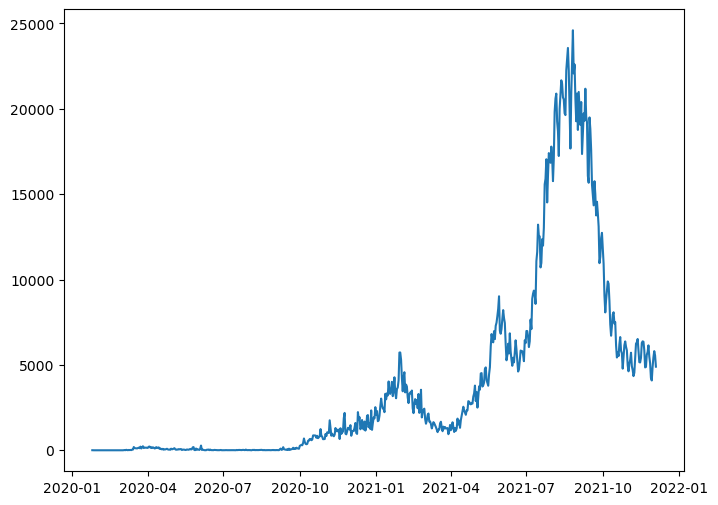

In [13]:
#interpolate the NAN value
train_df = train_df.interpolate()
print(train_df['cases_new'].isna().sum()) # Finally, no Nans
X_train = train_df.loc[:,'cases_new']

test_df = test_df.interpolate()
print(test_df['cases_new'].isna().sum()) # Finally, no Nans
X_test = test_df.loc[:,'cases_new']

plt.figure()
plt.plot(train_df['cases_new'])
plt.show()

In [14]:
X = train_df['cases_new'] #Only 1 Feature

mms = MinMaxScaler()

X = mms.fit_transform(np.expand_dims(X,axis=-1))

#Split the train data each of the 30 days
window_size = 30
X_train = []
y_train = []

for i in range(window_size,len(X)):
    X_train.append(X[i-window_size:i])
    y_train.append(X[i])

X_train = np.array(X_train)
y_train = np.array(y_train)

In [15]:
dataset_cat = pd.concat((train_df['cases_new'],test_df['cases_new']))

length_days = len(dataset_cat)-len(test_df)-window_size
tot_input = dataset_cat[length_days:]

Xtest = test_df['cases_new']
Xtest = mms.transform(np.expand_dims(tot_input,axis=-1))

#Split the test data each of 30 days
X_test = []
y_test = []

for i in range(window_size,len(Xtest)): 
    X_test.append(Xtest[i-window_size:i]) 
    y_test.append(Xtest[i])

X_test = np.array(X_test)
y_test = np.array(y_test)

In [16]:
class ModelDevelopment:

    def multi_lstm_model(self,input_shape,nb_class,nodes=64,dropout=0.3):
        model = tf.keras.Sequential()
        model.add(tf.keras.Input(shape=(input_shape))) #LSTM,RNN, GRU only accepts 3D array
        model.add(tf.keras.layers.LSTM(64,return_sequences=(True)))
        model.add(tf.keras.layers.Dropout(dropout))
        model.add(tf.keras.layers.LSTM(64,return_sequences=(True)))
        model.add(tf.keras.layers.Dropout(dropout))
        model.add(tf.keras.layers.LSTM(64))
        model.add(tf.keras.layers.Dropout(dropout))
        model.add(tf.keras.layers.Dense(1,activation='relu'))
        model.summary()
        return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            16896     
                                                                 
 dropout (Dropout)           (None, 30, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 64)            33024     
                                                                 
 dropout_1 (Dropout)         (None, 30, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 6

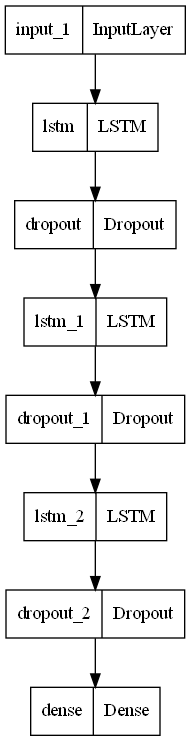

In [17]:
input_shape = np.shape(X_train)[1:]

md = ModelDevelopment()

model = md.multi_lstm_model(input_shape,nb_class=1,nodes=64,dropout=0.2)

tf.keras.utils.plot_model(model,show_shapes=True,show_layer_names=True)

model.compile(optimizer='adam',
              loss='mse',
              metrics=['mean_absolute_percentage_error','mse'])

tensorboard_callback = TensorBoard(LOGS_PATH)
early_callback = EarlyStopping(monitor='val_mse',patience=3)

tf.keras.utils.plot_model(model,show_shapes=False,show_layer_names=True)

In [18]:
hist = model.fit(X_train,y_train,
                 epochs=20,
                 callbacks=[tensorboard_callback,early_callback],
                 validation_data=(X_test,y_test))

model.save(MODEL_PATH)

predicted_new_case = model.predict(X_test)

Epoch 1/20
21/21 [==============================] - 9s 98ms/step - loss: 0.0209 - mean_absolute_percentage_error: 155282.9219 - mse: 0.0209 - val_loss: 0.0502 - val_mean_absolute_percentage_error: 27.7989 - val_mse: 0.0502
Epoch 2/20
21/21 [==============================] - 0s 21ms/step - loss: 0.0052 - mean_absolute_percentage_error: 118813.0703 - mse: 0.0052 - val_loss: 0.0508 - val_mean_absolute_percentage_error: 27.1742 - val_mse: 0.0508
Epoch 3/20
21/21 [==============================] - 0s 21ms/step - loss: 0.0037 - mean_absolute_percentage_error: 37489.7852 - mse: 0.0037 - val_loss: 0.0508 - val_mean_absolute_percentage_error: 23.3962 - val_mse: 0.0508
Epoch 4/20
21/21 [==============================] - 1s 25ms/step - loss: 0.0045 - mean_absolute_percentage_error: 75196.0156 - mse: 0.0045 - val_loss: 0.0398 - val_mean_absolute_percentage_error: 22.1275 - val_mse: 0.0398
Epoch 5/20
21/21 [==============================] - 0s 23ms/step - loss: 0.0032 - mean_absolute_percentage_err

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_absolute_error,accuracy_score

class ModelEvaluation():
    
    def cr(self, y_true, y_pred):
        print(classification_report(y_true, y_pred))
        print(confusion_matrix(y_true, y_pred))
        print(accuracy_score(y_true, y_pred))

    def model_graph(self,y,x):
        plt.figure()
        plt.plot(y,color='red')
        plt.plot(x,color='blue')
        plt.xlabel('Day')
        plt.ylabel('Covid19 Cases')
        plt.legend(['Actual','Predicted'])
        plt.show()

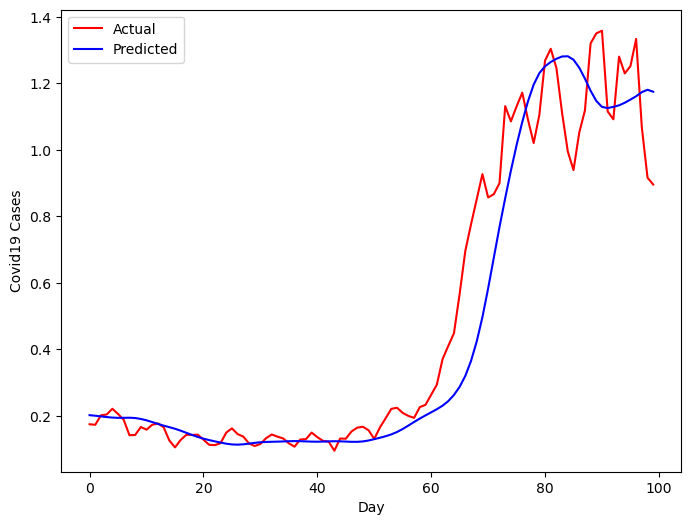

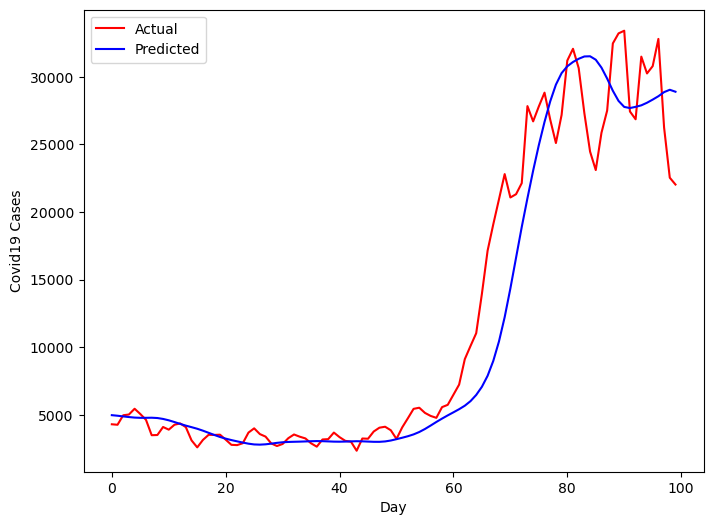

In [20]:
me = ModelEvaluation()
me.model_graph(y_test,predicted_new_case)

actual_case = mms.inverse_transform(y_test)
predicted_case = mms.inverse_transform(predicted_new_case)

me.model_graph(actual_case,predicted_case)
     

In [21]:
print('Mean Absolute error: ', mean_absolute_error(actual_case, predicted_case))
print('Mean Squared Error: ',mean_squared_error(actual_case, predicted_case))

Mean Absolute error:  2064.0941137695313
Mean Squared Error:  10947623.908159403


In [22]:
class Performance():
        
    def mape(self, y_true, y_pred):
        print(f"MAPE prediction is: {(mean_absolute_error(y_true, y_pred)/sum(abs(y_true))) * 100}%")

In [23]:
evaluate = Performance()
evaluate.mape(y_true=actual_case, y_pred=predicted_case)

MAPE prediction is: [0.17317795]%
